In [1]:
%config InlineBackend.figure_format='retina'

# Add the parent directory to the path so that we can import the modules.
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import pandas as pd

from dynamic_contagion import *
from market_conditions import *
from reinsurance import *

In [2]:
# Other parameters
maturity = 3
markup = 0.4
R = int(1e5)
seed = 123

# Asset parameters
V_0 = 130
phi_V = -3  # * (1.3) # = V0 / L0
sigma_V = 0.05

# Liability parameters
L_0 = 100
phi_L = -3
sigma_L = 0.02

# Interest rate parameters
r_0 = 0.02
k = 0.2
m = 0.05  # 0.5
upsilon = 0.1
eta_r = -0.01

In [3]:
all_time_series = get_market_conditions(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
)

V_T, L_T, int_r_t = summarise_market_conditions(all_time_series, maturity)

In [4]:
assert np.isnan(all_time_series).mean() == 0

## Generate catastrophe scenarios

In [5]:
# Poisson process
def simulate_poisson(seed):
    lambda_ = 0.5
    rg = rnd.default_rng(seed)
    return rg.poisson(lambda_ * maturity)


# Cox proces
def simulate_cox(seed):
    lambda0 = 0.49
    a = 0.4
    rho = 0.4
    delta = 1

    rg = rnd.default_rng(seed)
    selfJumpSizeDist = lambda rg: 0
    extJumpSizeDist = lambda rg: rg.uniform(0, 0.5)

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )


# Hawkes process
def simulate_hawkes(seed):
    lambda0 = 0.47
    a = 0.26
    rho = 0.4
    delta = 1

    rg = rnd.default_rng(seed)
    selfJumpSizeDist = lambda rg: rg.uniform()
    extJumpSizeDist = lambda rg: 0

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )


# Dynamic contagion process
def simulate_dcp(seed):
    lambda0 = 0.29
    a = 0.26
    rho = 0.4
    delta = 1

    rg = rnd.default_rng(seed)
    selfJumpSizeDist = lambda rg: rg.uniform()
    extJumpSizeDist = lambda rg: rg.uniform(0, 0.5)

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )

In [6]:
%%time
# Catastrophe loss size distribution parameters
mu_C = 2
sigma_C = 0.5

seed = 123

C_T_poisson, num_cats_poisson = simulate_catastrophe_losses(
    seed, R, simulate_poisson, mu_C, sigma_C
)

C_T_cox, num_cats_cox = simulate_catastrophe_losses(
    seed, R, simulate_cox, mu_C, sigma_C
)

C_T_hawkes, num_cats_hawkes = simulate_catastrophe_losses(
    seed, R, simulate_hawkes, mu_C, sigma_C
)

C_T_dcp, num_cats_dcp = simulate_catastrophe_losses(
    seed, R, simulate_dcp, mu_C, sigma_C
)

CPU times: user 6.97 s, sys: 93.8 ms, total: 7.07 s
Wall time: 7.07 s


In [7]:
# Poisson process
def simulate_poisson(seed):
    lambda_ = 0.5
    rg = rnd.default_rng(seed)
    return rg.poisson(lambda_ * maturity)


# Cox proces
def simulate_cox(seed):
    lambda0 = 0.49
    a = 0.4
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 0.0, 0.0, 0.5
    )


# Hawkes process
def simulate_hawkes(seed):
    lambda0 = 0.47
    a = 0.26
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 1.0, 0.0, 0.0
    )


# Dynamic contagion process
def simulate_dcp(seed):
    lambda0 = 0.29
    a = 0.26
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 1.0, 0.0, 0.5
    )

In [8]:
%%time
# Catastrophe loss size distribution parameters
mu_C = 2
sigma_C = 0.5

seed = 123

C_T_poisson, num_cats_poisson = simulate_catastrophe_losses(
    seed, R, simulate_poisson, mu_C, sigma_C
)

C_T_cox, num_cats_cox = simulate_catastrophe_losses(
    seed, R, simulate_cox, mu_C, sigma_C
)

C_T_hawkes, num_cats_hawkes = simulate_catastrophe_losses(
    seed, R, simulate_hawkes, mu_C, sigma_C
)

C_T_dcp, num_cats_dcp = simulate_catastrophe_losses(
    seed, R, simulate_dcp, mu_C, sigma_C
)

CPU times: user 2.49 s, sys: 44.3 ms, total: 2.53 s
Wall time: 2.53 s


In [9]:
print(
    f"Average number of catastrophes from Poisson process: {np.mean(num_cats_poisson):.2f}"
)
print(f"Average number of catastrophes from Cox process: {np.mean(num_cats_cox):.2f}")
print(
    f"Average number of catastrophes from Hawkes process: {np.mean(num_cats_hawkes):.2f}"
)
print(
    f"Average number of catastrophes from dynamic contagion process: {np.mean(num_cats_dcp):.2f}"
)

Average number of catastrophes from Poisson process: 1.50
Average number of catastrophes from Cox process: 1.49
Average number of catastrophes from Hawkes process: 1.48
Average number of catastrophes from dynamic contagion process: 1.49


In [10]:
print(
    f"Mean/variance catastrophe loss from Poisson process: {np.mean(C_T_poisson):.2f}, {np.var(C_T_poisson):.2f}"
)
print(
    f"Mean/variance catastrophe loss from Cox process: {np.mean(C_T_cox):.2f}, {np.var(C_T_cox):.2f}"
)
print(
    f"Mean/variance catastrophe loss from Hawkes process: {np.mean(C_T_hawkes):.2f}, {np.var(C_T_hawkes):.2f}"
)
print(
    f"Mean/variance catastrophe loss from dynamic contagion process: {np.mean(C_T_dcp):.2f}, {np.var(C_T_dcp):.2f}"
)

Mean/variance catastrophe loss from Poisson process: 12.53, 134.95
Mean/variance catastrophe loss from Cox process: 12.47, 138.13
Mean/variance catastrophe loss from Hawkes process: 12.38, 269.68
Mean/variance catastrophe loss from dynamic contagion process: 12.46, 269.36


In [11]:
print(
    f"Min/max catastrophe loss from Poisson process: {np.min(C_T_poisson):.2f}, {np.max(C_T_poisson):.2f}"
)
print(
    f"Min/max catastrophe loss from Cox process: {np.min(C_T_cox):.2f}, {np.max(C_T_cox):.2f}"
)
print(
    f"Min/max catastrophe loss from Hawkes process: {np.min(C_T_hawkes):.2f}, {np.max(C_T_hawkes):.2f}"
)
print(
    f"Min/max catastrophe loss from dynamic contagion process: {np.min(C_T_dcp):.2f}, {np.max(C_T_dcp):.2f}"
)

Min/max catastrophe loss from Poisson process: 0.00, 107.04
Min/max catastrophe loss from Cox process: 0.00, 113.80
Min/max catastrophe loss from Hawkes process: 0.00, 228.34
Min/max catastrophe loss from dynamic contagion process: 0.00, 219.89


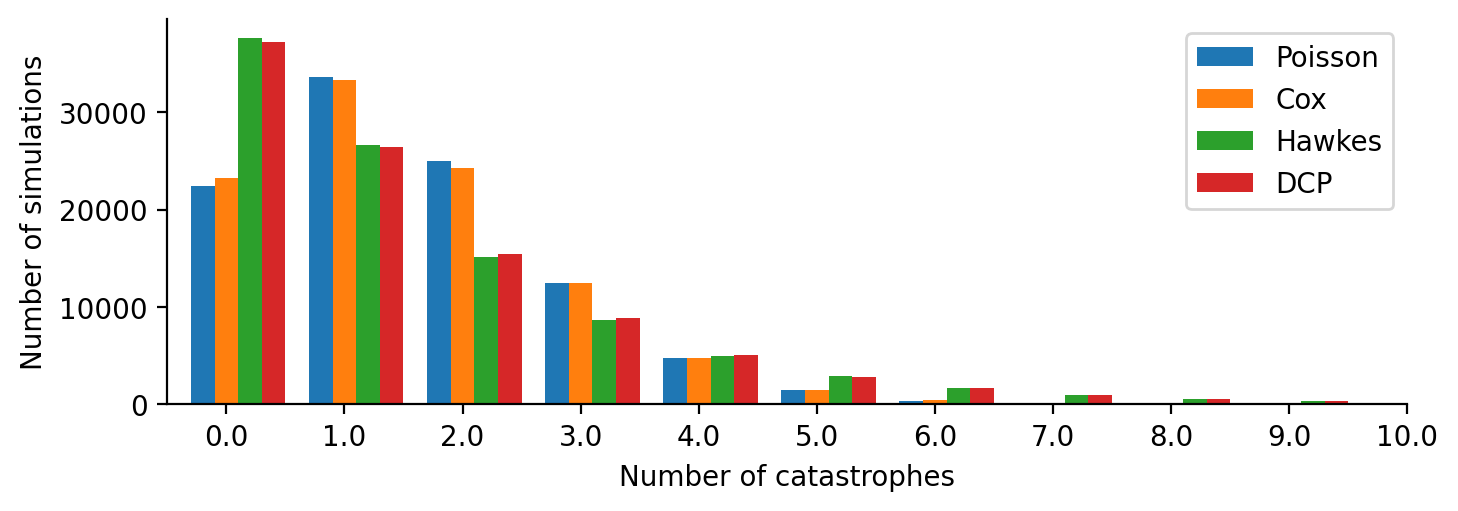

In [12]:
# Plot a grouped vertical bar charts showing the number of simulations which had `n` catastrophes according to each of the arrival processes.
def plot_num_cats(num_cats_poisson, num_cats_cox, num_cats_hawkes, num_cats_dcp):
    num_cats_poisson = np.floor(num_cats_poisson)
    num_cats_cox = np.floor(num_cats_cox)
    num_cats_hawkes = np.floor(num_cats_hawkes)
    num_cats_dcp = np.floor(num_cats_dcp)

    max_cats = np.max(
        [
            np.max(num_cats_poisson),
            np.max(num_cats_cox),
            np.max(num_cats_hawkes),
            np.max(num_cats_dcp),
        ]
    )
    min_cats = np.min(
        [
            np.min(num_cats_poisson),
            np.min(num_cats_cox),
            np.min(num_cats_hawkes),
            np.min(num_cats_dcp),
        ]
    )

    num_bins = int(max_cats - min_cats + 1)

    bins = np.linspace(min_cats, max_cats, num_bins + 1)
    bins = np.floor(bins)

    hist_poisson, _ = np.histogram(num_cats_poisson, bins=bins)
    hist_cox, _ = np.histogram(num_cats_cox, bins=bins)
    hist_hawkes, _ = np.histogram(num_cats_hawkes, bins=bins)
    hist_dcp, _ = np.histogram(num_cats_dcp, bins=bins)

    width = 0.2
    x = np.arange(len(bins) - 1)

    plt.bar(x - width, hist_poisson, width, label="Poisson")
    plt.bar(x, hist_cox, width, label="Cox")
    plt.bar(x + width, hist_hawkes, width, label="Hawkes")
    plt.bar(x + 2 * width, hist_dcp, width, label="DCP")

    plt.xticks(x, bins[:-1])
    plt.legend()

    plt.xlim(0.5, 11.0)
    plt.xlabel("Number of catastrophes")
    plt.ylabel("Number of simulations")

    # Change the aspect ratio to be wider
    plt.gcf().set_size_inches(8, 2.5)

    # Remove the top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)


plot_num_cats(num_cats_poisson, num_cats_cox, num_cats_hawkes, num_cats_dcp)
plt.savefig("num_catastrophe_hists.png")

## Tables 1-4 (LaTeX)

In [13]:
ROUNDING = 4

In [14]:
prices_poisson = calculate_prices(V_T, L_T, int_r_t, C_T_poisson, markup).round(
    ROUNDING
)
display(prices_poisson)
print(
    prices_poisson.style.to_latex()
    .replace("00 ", " ")
    .replace("lrrrrrrr", "c|c|c|c|c|c|c|c")
)

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,7.2393,7.2459,7.2490,7.2506,7.2514,7.2517,7.2519
$A=15$,4.5757,4.5828,4.5861,4.5878,4.5887,4.5891,4.5893
$A=20$,2.7836,2.7914,2.7949,2.7968,2.7977,2.7981,2.7983
$A=25$,1.6387,1.6471,1.6511,1.6530,1.6540,1.6544,1.6547
$A=30$,0.9342,0.9433,0.9476,0.9498,0.9508,0.9513,0.9516


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 7.2393 & 7.2459 & 7.2490 & 7.2506 & 7.2514 & 7.2517 & 7.2519 \\
$A=15$ & 4.5757 & 4.5828 & 4.5861 & 4.5878 & 4.5887 & 4.5891 & 4.5893 \\
$A=20$ & 2.7836 & 2.7914 & 2.7949 & 2.7968 & 2.7977 & 2.7981 & 2.7983 \\
$A=25$ & 1.6387 & 1.6471 & 1.6511 & 1.6530 & 1.6540 & 1.6544 & 1.6547 \\
$A=30$ & 0.9342 & 0.9433 & 0.9476 & 0.9498 & 0.9508 & 0.9513 & 0.9516 \\
\end{tabular}



In [15]:
prices_cox = calculate_prices(V_T, L_T, int_r_t, C_T_cox, markup).round(ROUNDING)
display(prices_cox)
print(
    prices_cox.style.to_latex()
    .replace("00 ", " ")
    .replace("lrrrrrrr", "c|c|c|c|c|c|c|c")
)

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,7.2455,7.2528,7.2564,7.2577,7.2583,7.2586,7.2588
$A=15$,4.6069,4.6148,4.6187,4.6201,4.6207,4.6211,4.6213
$A=20$,2.8289,2.8374,2.8417,2.8432,2.8439,2.8443,2.8444
$A=25$,1.6869,1.6962,1.7008,1.7025,1.7032,1.7036,1.7038
$A=30$,0.9810,0.9911,0.9962,0.9980,0.9988,0.9992,0.9994


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 7.2455 & 7.2528 & 7.2564 & 7.2577 & 7.2583 & 7.2586 & 7.2588 \\
$A=15$ & 4.6069 & 4.6148 & 4.6187 & 4.6201 & 4.6207 & 4.6211 & 4.6213 \\
$A=20$ & 2.8289 & 2.8374 & 2.8417 & 2.8432 & 2.8439 & 2.8443 & 2.8444 \\
$A=25$ & 1.6869 & 1.6962 & 1.7008 & 1.7025 & 1.7032 & 1.7036 & 1.7038 \\
$A=30$ & 0.9810 & 0.9911 & 0.9962 & 0.9980 & 0.9988 & 0.9992 & 0.9994 \\
\end{tabular}



In [16]:
prices_hawkes = calculate_prices(V_T, L_T, int_r_t, C_T_hawkes, markup).round(ROUNDING)
display(prices_hawkes)
print(
    prices_hawkes.style.to_latex()
    .replace("00 ", " ")
    .replace("lrrrrrrr", "c|c|c|c|c|c|c|c")
)

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,8.0602,8.1339,8.1847,8.2201,8.2455,8.2633,8.2761
$A=15$,5.8893,5.9693,6.0242,6.0621,6.0892,6.1080,6.1215
$A=20$,4.2772,4.3644,4.4240,4.4649,4.4939,4.5140,4.5282
$A=25$,3.0838,3.1792,3.2441,3.2886,3.3199,3.3415,3.3567
$A=30$,2.1903,2.2936,2.3645,2.4129,2.4469,2.4702,2.4865


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 8.0602 & 8.1339 & 8.1847 & 8.2201 & 8.2455 & 8.2633 & 8.2761 \\
$A=15$ & 5.8893 & 5.9693 & 6.0242 & 6.0621 & 6.0892 & 6.1080 & 6.1215 \\
$A=20$ & 4.2772 & 4.3644 & 4.4240 & 4.4649 & 4.4939 & 4.5140 & 4.5282 \\
$A=25$ & 3.0838 & 3.1792 & 3.2441 & 3.2886 & 3.3199 & 3.3415 & 3.3567 \\
$A=30$ & 2.1903 & 2.2936 & 2.3645 & 2.4129 & 2.4469 & 2.4702 & 2.4865 \\
\end{tabular}



In [17]:
prices_dcp = calculate_prices(V_T, L_T, int_r_t, C_T_dcp, markup).round(ROUNDING)
display(prices_dcp)
print(
    prices_dcp.style.to_latex()
    .replace("00 ", " ")
    .replace("lrrrrrrr", "c|c|c|c|c|c|c|c")
)

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,8.1381,8.2089,8.2574,8.2913,8.3157,8.3329,8.3454
$A=15$,5.9360,6.0128,6.0652,6.1014,6.1273,6.1455,6.1587
$A=20$,4.3044,4.3884,4.4452,4.4844,4.5121,4.5314,4.5454
$A=25$,3.0967,3.1887,3.2509,3.2934,3.3234,3.3441,3.3589
$A=30$,2.2006,2.2999,2.3680,2.4147,2.4473,2.4696,2.4855


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 8.1381 & 8.2089 & 8.2574 & 8.2913 & 8.3157 & 8.3329 & 8.3454 \\
$A=15$ & 5.9360 & 6.0128 & 6.0652 & 6.1014 & 6.1273 & 6.1455 & 6.1587 \\
$A=20$ & 4.3044 & 4.3884 & 4.4452 & 4.4844 & 4.5121 & 4.5314 & 4.5454 \\
$A=25$ & 3.0967 & 3.1887 & 3.2509 & 3.2934 & 3.3234 & 3.3441 & 3.3589 \\
$A=30$ & 2.2006 & 2.2999 & 2.3680 & 2.4147 & 2.4473 & 2.4696 & 2.4855 \\
\end{tabular}



In [19]:
price_dcp = calculate_prices(V_T, L_T, int_r_t, C_T_dcp, markup, A=20, M=90)
price_dcp

4.545407562727567

In [20]:
%%time
prices = reinsurance_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup,
)

prices

CPU times: user 1.49 s, sys: 86.5 ms, total: 1.58 s
Wall time: 1.58 s


2.801521070833136